In [51]:
!pip install catboost
!pip install optuna


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/28/09/c4d329f7969443cdd4d482048ca406b6f61cda3c8e99ace71feaec7c8734/optuna-4.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/99/f7/d398fae160568472ddce0b3fde9c4581afc593019a6adc91006a66406991/alembic-1.15.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy>=1.4.2 from https://files.pythonhosted.org/packages/f5/76/297c532ea77c90e858a2967ba8ed62e8d9c503edc968b0c875361631cf1f/SQLAlchemy-2.0.38-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for tqdm from https

In [52]:
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
import catboost as cb
import time
from sklearn.metrics import roc_auc_score
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
train_data = pd.read_csv('/Users/nikitaskazutin/PyCharmMiscProject/titanic_spaceship_dataset/train.csv')
test_data = pd.read_csv('/Users/nikitaskazutin/PyCharmMiscProject/titanic_spaceship_dataset/test.csv')

In [9]:
def prepare_spaceship_data(train_data, test_data, val_size=0.2, random_state=42):

    print("Loading and preparing Spaceship Titanic data...")


    print(f"Training data: {train_data.shape[0]} rows, {train_data.shape[1]} columns")
    print(f"Test data: {test_data.shape[0]} rows, {test_data.shape[1]} columns")

    train_ids = train_data['PassengerId'].copy() if 'PassengerId' in train_data.columns else None
    test_ids = test_data['PassengerId'].copy() if 'PassengerId' in test_data.columns else None

    if 'Transported' in train_data.columns:
        y = train_data['Transported'].copy()
        if y.dtype == bool:
            y = y.astype(int)
            print("Converted boolean target to integer (0/1)")
        X = train_data.drop('Transported', axis=1)
    else:
        raise ValueError("No 'Transported' column found in training data")

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_size, random_state=random_state, stratify=y
    )

    print(f"Split into {X_train.shape[0]} training samples and {X_val.shape[0]} validation samples")

    dfs = [
        (X_train, 'train'),
        (X_val, 'val'),
        (test_data, 'test')
    ]

    combined = pd.concat([df.assign(source=source) for df, source in dfs], axis=0)


    if 'PassengerId' in combined.columns:
        combined['PassengerGroup'] = combined['PassengerId'].str.split('_').str[0].astype(int)
        combined['PassengerNumber'] = combined['PassengerId'].str.split('_').str[1].astype(int)


        group_sizes = combined['PassengerGroup'].value_counts()
        combined['GroupSize'] = combined['PassengerGroup'].map(group_sizes)
        combined['TravelingAlone'] = (combined['GroupSize'] == 1).astype(int)

    if 'Cabin' in combined.columns:
        combined['CabinDeck'] = 'Unknown'
        combined['CabinNum'] = np.nan
        combined['CabinSide'] = 'Unknown'
        combined['HasCabin'] = combined['Cabin'].notna().astype(int)


        cabin_mask = combined['Cabin'].notna()
        if cabin_mask.any():
            cabin_parts = combined.loc[cabin_mask, 'Cabin'].str.split('/', expand=True)
            if cabin_parts.shape[1] >= 3:
                combined.loc[cabin_mask, 'CabinDeck'] = cabin_parts[0]
                combined.loc[cabin_mask, 'CabinNum'] = pd.to_numeric(cabin_parts[1], errors='coerce')
                combined.loc[cabin_mask, 'CabinSide'] = cabin_parts[2]

    if 'Name' in combined.columns:
        combined['LastName'] = combined['Name'].str.split(' ').str[0]
        combined['FirstName'] = combined['Name'].str.split(' ').str[1:].str.join(' ')

        family_sizes = combined['LastName'].value_counts()
        combined['FamilySize'] = combined['LastName'].map(family_sizes)
        combined['HasFamily'] = (combined['FamilySize'] > 1).astype(int)

    num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in num_cols:
        if col in combined.columns:
            group_medians = combined.groupby('PassengerGroup')[col].transform('median')
            combined[col] = combined[col].fillna(group_medians)

            if 'HomePlanet' in combined.columns:
                planet_medians = combined.groupby('HomePlanet')[col].transform('median')
                combined[col] = combined[col].fillna(planet_medians)

            combined[col] = combined[col].fillna(combined[col].median())

    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    spending_cols = [col for col in spending_cols if col in combined.columns]
    if spending_cols:
        combined['TotalSpend'] = combined[spending_cols].sum(axis=1)
        combined['HasSpent'] = (combined['TotalSpend'] > 0).astype(int)

        combined['TotalSpendLog'] = np.log1p(combined['TotalSpend'])
        for col in spending_cols:
            combined[f'{col}Log'] = np.log1p(combined[col])

        for col in spending_cols:
            combined[f'{col}Ratio'] = 0
            spend_mask = combined['TotalSpend'] > 0
            if spend_mask.any():
                combined.loc[spend_mask, f'{col}Ratio'] = combined.loc[spend_mask, col] / combined.loc[spend_mask, 'TotalSpend']

        for col in spending_cols:
            combined[f'Used{col}'] = (combined[col] > 0).astype(int)

    cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
    cat_cols = [col for col in cat_cols if col in combined.columns]

    for col in cat_cols:
        for group in combined[combined[col].isna()]['PassengerGroup'].unique():
            group_mode = combined[(combined['PassengerGroup'] == group) & combined[col].notna()][col].mode()
            if not group_mode.empty:
                combined.loc[(combined['PassengerGroup'] == group) & combined[col].isna(), col] = group_mode.iloc[0]

        combined[col] = combined[col].fillna(combined[col].mode().iloc[0])

    if 'Age' in combined.columns:
        combined['AgeGroup'] = pd.cut(
            combined['Age'],
            bins=[0, 12, 18, 25, 40, 60, 1000],
            labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'MiddleAge', 'Senior']
        )

    if 'CryoSleep' in combined.columns and 'TotalSpend' in combined.columns:
        combined['ActiveSpender'] = ((combined['CryoSleep'] == False) & (combined['TotalSpend'] > 0)).astype(int)
        combined['CryoSleepSpender'] = ((combined['CryoSleep'] == True) & (combined['TotalSpend'] > 0)).astype(int)

    if 'HomePlanet' in combined.columns and 'Destination' in combined.columns:
        combined['Route'] = combined['HomePlanet'].astype(str) + "_to_" + combined['Destination'].astype(str)

    cols_to_drop = ['Name', 'Cabin', 'PassengerId']
    cols_to_drop = [col for col in cols_to_drop if col in combined.columns]
    combined = combined.drop(cols_to_drop, axis=1)
    cat_cols_to_encode = [
        col for col in combined.columns
        if col != 'source' and (
            combined[col].dtype == 'object' or
            isinstance(combined[col].dtype, pd.CategoricalDtype)
        )
    ]

    combined = pd.get_dummies(combined, columns=cat_cols_to_encode, drop_first=True)

    print(f"After preprocessing: {combined.shape[1]-1} features created")

    X_train_proc = combined[combined['source'] == 'train'].drop('source', axis=1)
    X_val_proc = combined[combined['source'] == 'val'].drop('source', axis=1)
    X_test_proc = combined[combined['source'] == 'test'].drop('source', axis=1)

    all_cols = sorted(list(set(X_train_proc.columns) |
                          set(X_val_proc.columns) |
                          set(X_test_proc.columns)))

    for col in all_cols:
        if col not in X_train_proc.columns:
            X_train_proc[col] = 0
        if col not in X_val_proc.columns:
            X_val_proc[col] = 0
        if col not in X_test_proc.columns:
            X_test_proc[col] = 0

    for name, df in [('X_train_proc', X_train_proc), ('X_val_proc', X_val_proc), ('X_test_proc', X_test_proc)]:
        nan_cols = df.columns[df.isna().any()].tolist()

        if nan_cols:
            print(f"Found NaN values in {name} for columns: {nan_cols}")
            print("Filling remaining NaNs with appropriate values...")

            for col in nan_cols:
                if np.issubdtype(df[col].dtype, np.number):
                    fill_value = df[col].median()
                    if pd.isna(fill_value):
                        fill_value = 0
                    df[col] = df[col].fillna(fill_value)
                    print(f"  - {col}: filled with median ({fill_value})")
                else:
                    fill_value = df[col].mode().iloc[0] if not df[col].mode().empty else "Unknown"
                    df[col] = df[col].fillna(fill_value)
                    print(f"  - {col}: filled with mode ({fill_value})")

    if 'Age' in combined.columns:
        combined['Age_squared'] = combined['Age'] ** 2

    if 'Age' in combined.columns and 'CryoSleep' in combined.columns:
        combined['Age_CryoSleep'] = combined['Age'] * combined['CryoSleep'].astype(int)

    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    spending_cols = [col for col in spending_cols if col in combined.columns]

    if spending_cols and 'GroupSize' in combined.columns:
        combined['SpendPerPerson'] = combined['TotalSpend'] / combined['GroupSize']

        combined['SpendingDiversity'] = (combined[spending_cols] > 0).sum(axis=1)

        combined['SpendingPercentile'] = pd.qcut(combined['TotalSpend'].rank(method='first'),
                                                q=10, labels=False, duplicates='drop')

    planet_map = {'Earth': 0, 'Europa': 1, 'Mars': 2}
    dest_map = {'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}

    if 'HomePlanet' in combined.columns and 'Destination' in combined.columns:
        combined['HomePlanetNum'] = combined['HomePlanet'].map(planet_map)
        combined['DestinationNum'] = combined['Destination'].map(dest_map)

        combined['HomePlanetNum'] = combined['HomePlanetNum'].fillna(-1)
        combined['DestinationNum'] = combined['DestinationNum'].fillna(-1)

        combined['TravelDistance'] = abs(combined['DestinationNum'] - combined['HomePlanetNum'])

    if 'VIP' in combined.columns and 'TotalSpend' in combined.columns:
        combined['VIP_Spending'] = combined['VIP'].astype(int) * combined['TotalSpend']
    all_clean = all([
        not X_train_proc.isna().any().any(),
        not X_val_proc.isna().any().any(),
        not X_test_proc.isna().any().any()
    ])

    if all_clean:
        print("All datasets are now free of NaN values!")
    else:
        print("WARNING: There are still NaN values remaining. Check your data processing.")

    X_train_proc = X_train_proc[sorted(X_train_proc.columns)]
    X_val_proc = X_val_proc[sorted(X_val_proc.columns)]
    X_test_proc = X_test_proc[sorted(X_test_proc.columns)]


    scaler = StandardScaler()

    scaler.fit(X_train_proc)


    X_train_proc = pd.DataFrame(
        scaler.transform(X_train_proc),
        columns=X_train_proc.columns,
        index=X_train_proc.index
    )

    X_val_proc = pd.DataFrame(
        scaler.transform(X_val_proc),
        columns=X_val_proc.columns,
        index=X_val_proc.index
    )

    X_test_proc = pd.DataFrame(
        scaler.transform(X_test_proc),
        columns=X_test_proc.columns,
        index=X_test_proc.index
    )

    print("Data scaling completed with StandardScaler")
    print(f"Processed training features: {X_train_proc.shape}")
    print(f"Processed validation features: {X_val_proc.shape}")
    print(f"Processed test features: {X_test_proc.shape}")

    return {
        'X_train': X_train_proc,
        'X_val': X_val_proc,
        'X_test': X_test_proc,
        'y_train': y_train,
        'y_val': y_val,
        'train_ids': train_ids,
        'test_ids': test_ids
    }


In [28]:
def train_base_models(data_dict, use_stratified_cv=True, cv_folds=5):

    from sklearn.model_selection import StratifiedKFold, cross_val_predict
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

    X_train = data_dict['X_train']
    X_val = data_dict['X_val']
    y_train = data_dict['y_train']
    y_val = data_dict['y_val']

    print("Training individual base models...")

    models = {
        'logistic': LogisticRegression(
            C=0.1,
            max_iter=1000,
            solver='liblinear',
            random_state=42
        ),
        'random_forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        'xgboost': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
        'catboost': cb.CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=0)
    }

    results = {}

    if use_stratified_cv:
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        print(f"Using {cv_folds}-fold StratifiedKFold cross-validation")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        model.fit(X_train, y_train)

        val_pred = model.predict(X_val)
        val_prob = model.predict_proba(X_val)[:, 1]

        accuracy = accuracy_score(y_val, val_pred)
        roc_auc = roc_auc_score(y_val, val_prob)

        if use_stratified_cv:
            cv_probs = cross_val_predict(
                model, X_train, y_train,
                cv=skf,
                method='predict_proba'
            )[:, 1]

            cv_auc = roc_auc_score(y_train, cv_probs)

            overfit_gap = roc_auc - cv_auc

            print(f"CV ROC AUC: {cv_auc:.4f}")
            print(f"Validation ROC AUC: {roc_auc:.4f}")
            print(f"Potential overfitting: {overfit_gap:.4f}")

            results[name] = {
                'model': model,
                'val_accuracy': accuracy,
                'val_auc': roc_auc,
                'cv_auc': cv_auc,
                'overfit_gap': overfit_gap,
                'val_predictions': val_pred,
                'val_probabilities': val_prob
            }
        else:
            results[name] = {
                'model': model,
                'val_accuracy': accuracy,
                'val_auc': roc_auc,
                'val_predictions': val_pred,
                'val_probabilities': val_prob
            }

        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation ROC AUC: {roc_auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val, val_pred))

    comparison_columns = ['Model', 'Accuracy', 'ROC AUC']
    if use_stratified_cv:
        comparison_columns.extend(['CV AUC', 'Overfit Gap'])

    comparison_data = {'Model': list(results.keys())}
    comparison_data['Accuracy'] = [results[m]['val_accuracy'] for m in results]
    comparison_data['ROC AUC'] = [results[m]['val_auc'] for m in results]

    if use_stratified_cv:
        comparison_data['CV AUC'] = [results[m]['cv_auc'] for m in results]
        comparison_data['Overfit Gap'] = [results[m]['overfit_gap'] for m in results]

    comparison = pd.DataFrame(comparison_data).sort_values('ROC AUC', ascending=False)

    print("\n=== Model Comparison ===")
    print(comparison)

    return results

In [11]:
class StackingEnsemble(BaseEstimator, ClassifierMixin):

    def __init__(self, base_models, meta_learner):

        self.base_models = base_models
        self.meta_learner = meta_learner
        self.fitted_base_models = None
        self.fitted_meta_learner = None

    def fit(self, X, y):

        self.fitted_base_models = {}

        meta_features = np.zeros((X.shape[0], len(self.base_models)))

        for i, (name, model) in enumerate(self.base_models.items()):
            print(f"Training base model: {name}")

            model.fit(X, y)

            self.fitted_base_models[name] = model

            if hasattr(model, "predict_proba"):
                meta_features[:, i] = model.predict_proba(X)[:, 1]
            else:
                meta_features[:, i] = model.predict(X)

        print("Training meta-learner")
        self.fitted_meta_learner = self.meta_learner.fit(meta_features, y)

        return self

    def predict(self, X):

        meta_features = np.zeros((X.shape[0], len(self.base_models)))

        for i, (name, model) in enumerate(self.fitted_base_models.items()):
            if hasattr(model, "predict_proba"):
                meta_features[:, i] = model.predict_proba(X)[:, 1]
            else:
                meta_features[:, i] = model.predict(X)

        return self.fitted_meta_learner.predict(meta_features)

    def predict_proba(self, X):

        meta_features = np.zeros((X.shape[0], len(self.base_models)))


        for i, (name, model) in enumerate(self.fitted_base_models.items()):
            if hasattr(model, "predict_proba"):
                meta_features[:, i] = model.predict_proba(X)[:, 1]
            else:
                meta_features[:, i] = model.predict(X)

        return self.fitted_meta_learner.predict_proba(meta_features)

In [53]:
def build_advanced_ensemble(X_train, y_train, X_val, y_val, X_test):
    from sklearn.linear_model import LogisticRegression
    import xgboost as xgb
    import catboost as cb
    import numpy as np
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
    import optuna
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    import os
    import time

    start_time = time.time()

    # Replace GridSearchCV with Optuna-based optimization
    base_models = tune_base_models_with_optuna(
        X_train,
        y_train,
        cv=5,
        n_trials=50,  # Adjust based on your time constraints
        timeout=1800,  # 30 minutes per model max
        random_state=42
    )

    expected_models = ['logistic', 'xgboost', 'catboost']
    for model_name in expected_models:
        if model_name not in base_models:
            print(f"Warning: {model_name} is missing from base_models!")

    meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
    meta_features_val = np.zeros((X_val.shape[0], len(base_models)))
    meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

    used_models = []

    i = 0
    for name, model in base_models.items():
        print(f"Generating meta-features from {name}...")
        used_models.append(name)

        try:
            _ = model.predict(X_train[:1])
        except:
            print(f"Model {name} wasn't fitted, fitting now...")
            model.fit(X_train, y_train)

        if hasattr(model, "predict_proba"):
            meta_features_train[:, i] = model.predict_proba(X_train)[:, 1]
            meta_features_val[:, i] = model.predict_proba(X_val)[:, 1]
            meta_features_test[:, i] = model.predict_proba(X_test)[:, 1]
        else:
            meta_features_train[:, i] = model.predict(X_train)
            meta_features_val[:, i] = model.predict(X_val)
            meta_features_test[:, i] = model.predict(X_test)

        i += 1

    print(f"Generated meta-features from {len(used_models)} models: {', '.join(used_models)}")

    # Now let's also optimize the meta-learners with Optuna!
    def optimize_meta_learner(model_type, X, y, cv=5):
        """Optimize meta-learner hyperparameters with Optuna"""
        cv_object = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

        if model_type == 'logistic':
            def objective(trial):
                C = trial.suggest_float('C', 0.001, 10.0, log=True)
                model = LogisticRegression(C=C, max_iter=2000, random_state=42)
                scores = cross_val_score(model, X, y, cv=cv_object, scoring='roc_auc')
                return scores.mean()

            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=30)

            best_params = study.best_params
            print(f"Best logistic meta-learner params: {best_params}")
            return LogisticRegression(C=best_params['C'], max_iter=2000, random_state=42)

        elif model_type == 'xgb':
            def objective(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                    'max_depth': trial.suggest_int('max_depth', 2, 5),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                }
                model = xgb.XGBClassifier(**params, random_state=42)
                scores = cross_val_score(model, X, y, cv=cv_object, scoring='roc_auc')
                return scores.mean()

            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=30)

            best_params = study.best_params
            print(f"Best XGBoost meta-learner params: {best_params}")
            return xgb.XGBClassifier(**best_params, random_state=42)

        elif model_type == 'catboost':
            def objective(trial):
                params = {
                    'iterations': trial.suggest_int('iterations', 50, 200),
                    'depth': trial.suggest_int('depth', 2, 5),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                }
                model = cb.CatBoostClassifier(**params, random_state=42, verbose=0)
                scores = cross_val_score(model, X, y, cv=cv_object, scoring='roc_auc')
                return scores.mean()

            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=30)

            best_params = study.best_params
            print(f"Best CatBoost meta-learner params: {best_params}")
            return cb.CatBoostClassifier(**best_params, random_state=42, verbose=0)

    meta_learners = {}
    for model_type in ['logistic', 'xgb', 'catboost']:
        print(f"Optimizing meta-learner: {model_type}...")
        optimized_model = optimize_meta_learner(model_type, meta_features_train, y_train)
        optimized_model.fit(meta_features_train, y_train)
        meta_learners[model_type] = optimized_model

    meta_preds_val = {}
    meta_preds_test = {}

    for name, model in meta_learners.items():
        print(f"Evaluating meta-learner: {name}...")

        if hasattr(model, "predict_proba"):
            val_pred = model.predict_proba(meta_features_val)[:, 1]
        else:
            val_pred = model.predict(meta_features_val)

        acc = accuracy_score(y_val, (val_pred > 0.5).astype(int))
        auc = roc_auc_score(y_val, val_pred)
        print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")

        meta_preds_val[name] = val_pred
        meta_preds_test[name] = model.predict_proba(meta_features_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(meta_features_test)

    print("\nOptimizing ensemble weights...")

    def objective(trial):
        raw_weights = [
            trial.suggest_float(f'weight_{name}', 0.1, 1.0)
            for name in meta_preds_val.keys()
        ]

        weights_sum = sum(raw_weights)
        normalized_weights = [w / weights_sum for w in raw_weights]

        weighted_preds = np.zeros(len(X_val))
        for i, (name, pred) in enumerate(meta_preds_val.items()):
            weighted_preds += normalized_weights[i] * pred

        return roc_auc_score(y_val, weighted_preds)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    raw_weights = [
        study.best_params[f'weight_{name}']
        for name in meta_preds_val.keys()
    ]
    weights_sum = sum(raw_weights)
    weights = {
        name: raw_weights[i] / weights_sum
        for i, name in enumerate(meta_preds_val.keys())
    }

    print("\nOptimized meta-learner weights:")
    for name, weight in weights.items():
        print(f"{name}: {weight:.4f}")

    final_preds = np.zeros(len(X_test))
    for i, (name, pred) in enumerate(meta_preds_test.items()):
        final_preds += weights[name] * pred

    final_val_preds = np.zeros(len(X_val))
    for i, (name, pred) in enumerate(meta_preds_val.items()):
        final_val_preds += weights[name] * pred

    default_threshold = 0.5
    default_val_preds = (final_val_preds > default_threshold).astype(int)
    default_acc = accuracy_score(y_val, default_val_preds)
    ensemble_auc = roc_auc_score(y_val, final_val_preds)

    print("\n===== DEFAULT THRESHOLD EVALUATION =====")
    print(f"Default Threshold: {default_threshold}")
    print(f"Validation Accuracy: {default_acc:.4f}")
    print(f"Validation AUC: {ensemble_auc:.4f}")

    print("\nDefault Classification Report:")
    print(classification_report(y_val, default_val_preds))

    print("\n===== THRESHOLD OPTIMIZATION WITH OPTUNA =====")

    def threshold_objective(trial):
        threshold = trial.suggest_float('threshold', 0.3, 0.7)
        preds = (final_val_preds > threshold).astype(int)
        return accuracy_score(y_val, preds)

    threshold_study = optuna.create_study(direction='maximize')
    threshold_study.optimize(threshold_objective, n_trials=100)

    optimal_threshold = threshold_study.best_params['threshold']
    optimal_acc = threshold_study.best_value

    optimal_val_preds = (final_val_preds > optimal_threshold).astype(int)

    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Optimal Validation Accuracy: {optimal_acc:.4f}")
    print(f"Improvement: {(optimal_acc - default_acc) * 100:.4f}%")

    print("\nOptimized Classification Report:")
    print(classification_report(y_val, optimal_val_preds))

    optimal_test_preds = (final_preds > optimal_threshold).astype(int)

    elapsed = time.time() - start_time
    print(f"\nTotal ensemble building time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

    return {
        'base_models': base_models,
        'meta_learners': meta_learners,
        'weights': weights,
        'final_predictions': final_preds,
        'final_binary_predictions': {
            'default': (final_preds > default_threshold).astype(int),
            'optimized': optimal_test_preds
        },
        'validation_predictions': final_val_preds,
        'validation_binary_predictions': {
            'default': default_val_preds,
            'optimized': optimal_val_preds
        },
        'thresholds': {
            'default': default_threshold,
            'optimal': optimal_threshold
        },
        'meta_features': {
            'train': meta_features_train,
            'val': meta_features_val,
            'test': meta_features_test
        },
        'performance': {
            'default_accuracy': default_acc,
            'optimal_accuracy': optimal_acc,
            'improvement': optimal_acc - default_acc,
            'auc': ensemble_auc
        },
        'optuna_studies': {
            'base_models': None,
            'meta_weights': study,
            'threshold': threshold_study
        }
    }

In [13]:
def check_nan_values(data_dict):

    results = {}

    for key in ['X_train', 'X_val', 'X_test']:
        if key in data_dict and data_dict[key] is not None:
            df = data_dict[key]

            has_nan = df.isna().any().any()

            if has_nan:
                nan_cols = df.columns[df.isna().any()].tolist()
                nan_counts = {col: df[col].isna().sum() for col in nan_cols}
                nan_percent = {col: (count / len(df) * 100) for col, count in nan_counts.items()}

                results[key] = {
                    'has_nan': True,
                    'nan_columns': nan_cols,
                    'nan_counts': nan_counts,
                    'nan_percentages': nan_percent
                }

                print(f"\n{key} contains NaN values:")
                for col in nan_cols:
                    print(f"  - {col}: {nan_counts[col]} NaNs ({nan_percent[col]:.2f}%)")
            else:
                results[key] = {'has_nan': False}
                print(f"\n{key} does not contain any NaN values.")

    return results

In [56]:
def tune_base_models(X_train, y_train, cv=5, use_stratified_cv=True):

    from sklearn.model_selection import GridSearchCV

    print("Tuning model hyperparameters...")

    param_grids = {
        'logistic': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2']
        },
        # 'random_forest': {
        #     'n_estimators': [100, 200],
        #     'max_depth': [8, 10, 12, 15],
        #     'min_samples_split': [2, 5, 10],
        #     'min_samples_leaf': [1, 2, 4]
        # },
        'xgboost': {
            'n_estimators': [100, 200],
            'max_depth': [4, 5, 6],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'catboost': {
            'iterations': [100, 200],
            'depth': [5, 6, 7],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [1, 3, 5, 7]
        }
    }

    base_estimators = {
        'logistic': LogisticRegression(random_state=42, max_iter=2000),
        #'random_forest': RandomForestClassifier(random_state=42),
        'xgboost': xgb.XGBClassifier(random_state=42),
        'catboost': cb.CatBoostClassifier(random_state=42, verbose=0)
    }

    best_models = {}

    if use_stratified_cv:
        stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        print(f"Using {cv}-fold StratifiedKFold cross-validation for hyperparameter tuning")
        cv_object = stratified_cv
    else:
        cv_object = cv

    for name, estimator in base_estimators.items():
        print(f"\nTuning {name}...")

        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grids[name],
            cv=cv_object,
            scoring='roc_auc',
            n_jobs=os.cpu_count()-1,
            verbose=2,
            return_train_score=True
        )

        grid_search.fit(X_train, y_train)
        elapsed = time.time() - start_time
        print(f"Grid search completed in {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best score: {grid_search.best_score_:.4f}")

        best_index = grid_search.best_index_
        if hasattr(grid_search, 'cv_results_') and 'mean_train_score' in grid_search.cv_results_:
            train_score = grid_search.cv_results_['mean_train_score'][best_index]
            cv_score = grid_search.best_score_
            overfit_gap = train_score - cv_score
            print(f"Train score: {train_score:.4f}")
            print(f"CV score: {cv_score:.4f}")
            print(f"Potential overfitting: {overfit_gap:.4f}")

        best_models[name] = grid_search.best_estimator_

        print(f"Best {name} parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")

    return best_models
def tune_base_models_with_optuna(
    X_train,
    y_train,
    cv=5,
    n_trials=200,
    timeout=None,
    random_state=42
):

    start_time = time.time()

    print("Tuning model hyperparameters with Optuna...")
    print(f"Using {cv}-fold StratifiedKFold cross-validation")

    best_models = {}


    cv_object = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    def optimize_logistic(trial):
        C = trial.suggest_float('C', 0.001, 100, log=True)
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        solver = 'liblinear'

        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            random_state=random_state,
            max_iter=2000
        )

        scores = cross_val_score(
            model, X_train, y_train,
            cv=cv_object,
            scoring='roc_auc',
            n_jobs=os.cpu_count()-1
        )

        return scores.mean()

    def optimize_xgboost(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.0, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
        }

        model = xgb.XGBClassifier(
            **params,
            random_state=random_state,
            use_label_encoder=False,
            eval_metric='logloss'
        )

        scores = cross_val_score(
            model, X_train, y_train,
            cv=cv_object,
            scoring='roc_auc',
            n_jobs=os.cpu_count()-1
        )

        return scores.mean()

    def optimize_catboost(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 50, 300),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
        }

        model = cb.CatBoostClassifier(
            **params,
            random_state=random_state,
            verbose=0
        )

        scores = cross_val_score(
            model, X_train, y_train,
            cv=cv_object,
            scoring='roc_auc',
            n_jobs=os.cpu_count()-1
        )

        return scores.mean()


    optimization_funcs = {
        'logistic': optimize_logistic,
        'xgboost': optimize_xgboost,
        'catboost': optimize_catboost
    }


    for model_name, objective_func in optimization_funcs.items():
        print(f"\nTuning {model_name}...")
        model_start_time = time.time()

        study = optuna.create_study(direction='maximize')
        study.optimize(objective_func, n_trials=n_trials, timeout=timeout)

        model_elapsed = time.time() - model_start_time
        print(f"Optimization completed in {model_elapsed:.2f} seconds ({model_elapsed/60:.2f} minutes)")

        best_params = study.best_params
        best_score = study.best_value
        print(f"Best parameters: {best_params}")
        print(f"Best CV score: {best_score:.4f}")

        if model_name == 'logistic':
            best_model = LogisticRegression(
                C=best_params['C'],
                penalty=best_params['penalty'],
                solver='liblinear',
                random_state=random_state,
                max_iter=2000
            )
        elif model_name == 'xgboost':
            best_model = xgb.XGBClassifier(
                **best_params,
                random_state=random_state,
                use_label_encoder=False,
                eval_metric='logloss'
            )
        elif model_name == 'catboost':
            best_model = cb.CatBoostClassifier(
                **best_params,
                random_state=random_state,
                verbose=0
            )

        best_model.fit(X_train, y_train)

        if hasattr(best_model, "predict_proba"):
            train_preds = best_model.predict_proba(X_train)[:, 1]
        else:
            train_preds = best_model.predict(X_train)

        from sklearn.metrics import roc_auc_score
        train_score = roc_auc_score(y_train, train_preds)
        cv_score = best_score
        overfit_gap = train_score - cv_score

        print(f"Train score: {train_score:.4f}")
        print(f"CV score: {cv_score:.4f}")
        print(f"Potential overfitting: {overfit_gap:.4f}")

        best_models[model_name] = best_model

        print(f"Number of finished trials: {len(study.trials)}")
        print(f"Best {model_name} parameters: {best_params}")
        print(f"Best CV score: {best_score:.4f}")


        optuna.visualization.plot_optimization_history(study)
        plt.title(f"{model_name} Optimization History")
        plt.show()

    total_elapsed = time.time() - start_time
    print(f"\nTotal hyperparameter tuning time: {total_elapsed:.2f} seconds ({total_elapsed/60:.2f} minutes)")

    return best_models

In [40]:
def select_best_features(X_train, y_train, X_val, X_test):

    from sklearn.feature_selection import SelectFromModel
    import xgboost as xgb

    print("Performing feature selection...")

    model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    selection = SelectFromModel(model, threshold='median', prefit=True).set_output(transform="pandas")

    X_train_selected = selection.transform(X_train)
    X_val_selected = selection.transform(X_val)
    X_test_selected = selection.transform(X_test)

    print(f"Selected {X_train_selected.shape[1]} features out of {X_train.shape[1]}")

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    })
    top_features = feature_importance.sort_values('Importance', ascending=False).head(10)
    print("Top 10 most important features:")
    print(top_features)

    return X_train_selected, X_val_selected, X_test_selected

In [41]:
def optimize_threshold(y_true, y_prob, metric='accuracy', thresholds=None):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    import numpy as np

    if thresholds is None:
        thresholds = np.arange(0.3, 0.7, 0.01)

    best_threshold = 0.5
    best_score = 0.0

    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)

        if metric == 'accuracy':
            score = accuracy_score(y_true, y_pred)
        elif metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        else:
            score = accuracy_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score


===== DATA PREPARATION =====
Loading and preparing Spaceship Titanic data...
Training data: 8693 rows, 14 columns
Test data: 4277 rows, 13 columns
Converted boolean target to integer (0/1)
Split into 6954 training samples and 1739 validation samples


/var/folders/4k/r28hjx957zd3v1xzgv0q81lr0000gn/T/ipykernel_37360/4228832619.py:134: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/4k/r28hjx957zd3v1xzgv0q81lr0000gn/T/ipykernel_37360/4228832619.py:134: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.         0.2699005  0.99688958 ... 0.99654378 0.83202358 0.83671558]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/4k/r28hjx957zd3v1xzgv0q81lr0000gn/T/ipykernel_37360/4228832619.py:134: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01152074 0.         0.         ... 0.         0.01669941 0.        ]' has dtype i

After preprocessing: 5350 features created
Found NaN values in X_train_proc for columns: ['CabinNum', 'FamilySize']
Filling remaining NaNs with appropriate values...
  - CabinNum: filled with median (429.0)
  - FamilySize: filled with median (6.0)
Found NaN values in X_val_proc for columns: ['CabinNum', 'FamilySize']
Filling remaining NaNs with appropriate values...
  - CabinNum: filled with median (420.0)
  - FamilySize: filled with median (6.0)
Found NaN values in X_test_proc for columns: ['CabinNum', 'FamilySize']
Filling remaining NaNs with appropriate values...
  - CabinNum: filled with median (442.0)
  - FamilySize: filled with median (6.0)
All datasets are now free of NaN values!
Processed training features: (6954, 5350)
Processed validation features: (1739, 5350)
Processed test features: (4277, 5350)

===== FEATURE SELECTION =====
Performing feature selection...


/Users/nikitaskazutin/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names

[I 2025-03-10 16:19:12,975] A new study created in memory with name: no-name-4951278d-90a8-49e0-9e8f-49087aeb2ecb


Selected 5350 features out of 5350
Top 10 most important features:
                        Feature  Importance
0                 ActiveSpender    0.697710
12                  CabinDeck_G    0.040102
18                    CryoSleep    0.017624
2430             FoodCourtRatio    0.015067
10                  CabinDeck_E    0.014080
5334          ShoppingMallRatio    0.012825
2436            HomePlanet_Mars    0.008964
16                  CabinSide_S    0.006110
2435          HomePlanet_Europa    0.005724
5331  Route_Mars_to_TRAPPIST-1e    0.005463

===== BUILDING ADVANCED ENSEMBLE =====
Tuning model hyperparameters with Optuna...
Using 5-fold StratifiedKFold cross-validation

Tuning logistic...


[I 2025-03-10 16:19:15,334] Trial 0 finished with value: 0.8776679432981893 and parameters: {'C': 0.03324785639616137, 'penalty': 'l2'}. Best is trial 0 with value: 0.8776679432981893.
[I 2025-03-10 16:19:16,652] Trial 1 finished with value: 0.874790276872516 and parameters: {'C': 0.027956626824766368, 'penalty': 'l1'}. Best is trial 0 with value: 0.8776679432981893.
[I 2025-03-10 16:19:18,002] Trial 2 finished with value: 0.8782037826063149 and parameters: {'C': 0.12722070144662892, 'penalty': 'l2'}. Best is trial 2 with value: 0.8782037826063149.
[I 2025-03-10 16:19:19,330] Trial 3 finished with value: 0.8747992206747511 and parameters: {'C': 0.008455934828511561, 'penalty': 'l2'}. Best is trial 2 with value: 0.8782037826063149.
[I 2025-03-10 16:19:20,539] Trial 4 finished with value: 0.8750747999204807 and parameters: {'C': 0.5972491356139578, 'penalty': 'l2'}. Best is trial 2 with value: 0.8782037826063149.
[I 2025-03-10 16:19:21,719] Trial 5 finished with value: 0.8781492899634795

Optimization completed in 61.91 seconds (1.03 minutes)
Best parameters: {'C': 0.6253863734301369, 'penalty': 'l1'}
Best CV score: 0.8786
Train score: 0.8945
CV score: 0.8786
Potential overfitting: 0.0159
Number of finished trials: 50
Best logistic parameters: {'C': 0.6253863734301369, 'penalty': 'l1'}
Best CV score: 0.8786


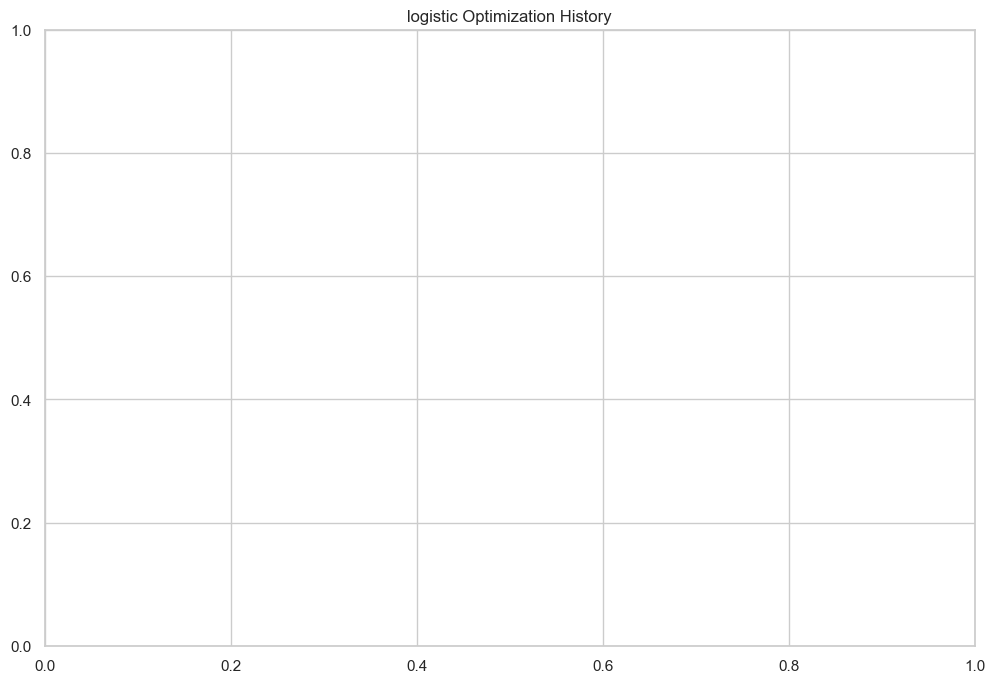

[I 2025-03-10 16:20:15,477] A new study created in memory with name: no-name-e1905832-1850-40ad-a153-d8191b30862d



Tuning xgboost...


/Users/nikitaskazutin/PyCharmMiscProject/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:20:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/nikitaskazutin/PyCharmMiscProject/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:20:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/nikitaskazutin/PyCharmMiscProject/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:20:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/nikitaskazutin/PyCharmMiscProject/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:20:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Pa

Optimization completed in 862.51 seconds (14.38 minutes)
Best parameters: {'n_estimators': 440, 'max_depth': 5, 'learning_rate': 0.01859925909414551, 'subsample': 0.8200477304861444, 'colsample_bytree': 0.999495136993001, 'min_child_weight': 1, 'gamma': 0.270167931432923, 'reg_alpha': 1.1510620732869116e-08, 'reg_lambda': 5.669623198561664e-07}
Best CV score: 0.8967


/Users/nikitaskazutin/PyCharmMiscProject/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[16:34:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Train score: 0.9427
CV score: 0.8967
Potential overfitting: 0.0459
Number of finished trials: 50
Best xgboost parameters: {'n_estimators': 440, 'max_depth': 5, 'learning_rate': 0.01859925909414551, 'subsample': 0.8200477304861444, 'colsample_bytree': 0.999495136993001, 'min_child_weight': 1, 'gamma': 0.270167931432923, 'reg_alpha': 1.1510620732869116e-08, 'reg_lambda': 5.669623198561664e-07}
Best CV score: 0.8967


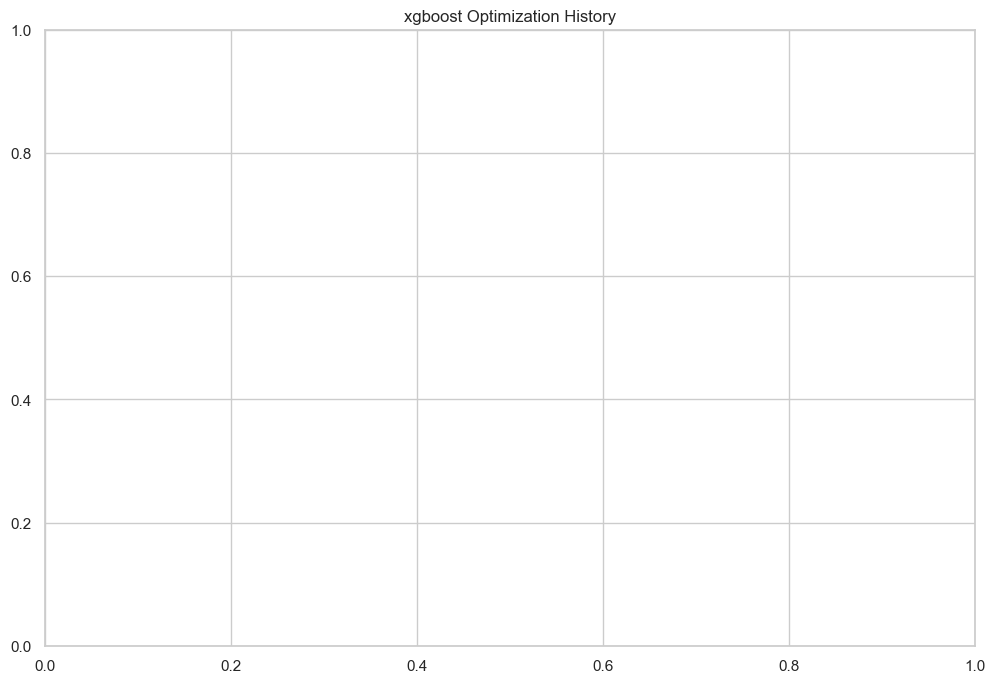

[I 2025-03-10 16:34:47,360] A new study created in memory with name: no-name-73c0eb90-b8d0-4c9b-9e84-b2d4bb40c96f



Tuning catboost...


[I 2025-03-10 16:35:04,464] Trial 0 finished with value: 0.891737613771651 and parameters: {'iterations': 234, 'depth': 9, 'learning_rate': 0.01824455348419317, 'l2_leaf_reg': 2.2068144276886437, 'bagging_temperature': 2.0504142682134283, 'random_strength': 1.19913036320027e-08, 'border_count': 130, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.891737613771651.
[I 2025-03-10 16:35:23,946] Trial 1 finished with value: 0.8890108782331204 and parameters: {'iterations': 236, 'depth': 9, 'learning_rate': 0.018063255367123672, 'l2_leaf_reg': 0.12790573751215514, 'bagging_temperature': 9.178019357706752, 'random_strength': 3.6959090845264e-07, 'border_count': 182, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.891737613771651.
[I 2025-03-10 16:35:38,006] Trial 2 finished with value: 0.8954444203411244 and parameters: {'iterations': 232, 'depth': 9, 'learning_rate': 0.021058401777615234, 'l2_leaf_reg': 0.17630764498301155, 'bagging_temperature': 7.154429498633785, 'ran

Optimization completed in 234.76 seconds (3.91 minutes)
Best parameters: {'iterations': 219, 'depth': 7, 'learning_rate': 0.04432388352713773, 'l2_leaf_reg': 2.0347149523243866, 'bagging_temperature': 0.5233595737286851, 'random_strength': 0.45418597524276966, 'border_count': 165, 'grow_policy': 'SymmetricTree'}
Best CV score: 0.8982
Train score: 0.9333
CV score: 0.8982
Potential overfitting: 0.0352
Number of finished trials: 50
Best catboost parameters: {'iterations': 219, 'depth': 7, 'learning_rate': 0.04432388352713773, 'l2_leaf_reg': 2.0347149523243866, 'bagging_temperature': 0.5233595737286851, 'random_strength': 0.45418597524276966, 'border_count': 165, 'grow_policy': 'SymmetricTree'}
Best CV score: 0.8982


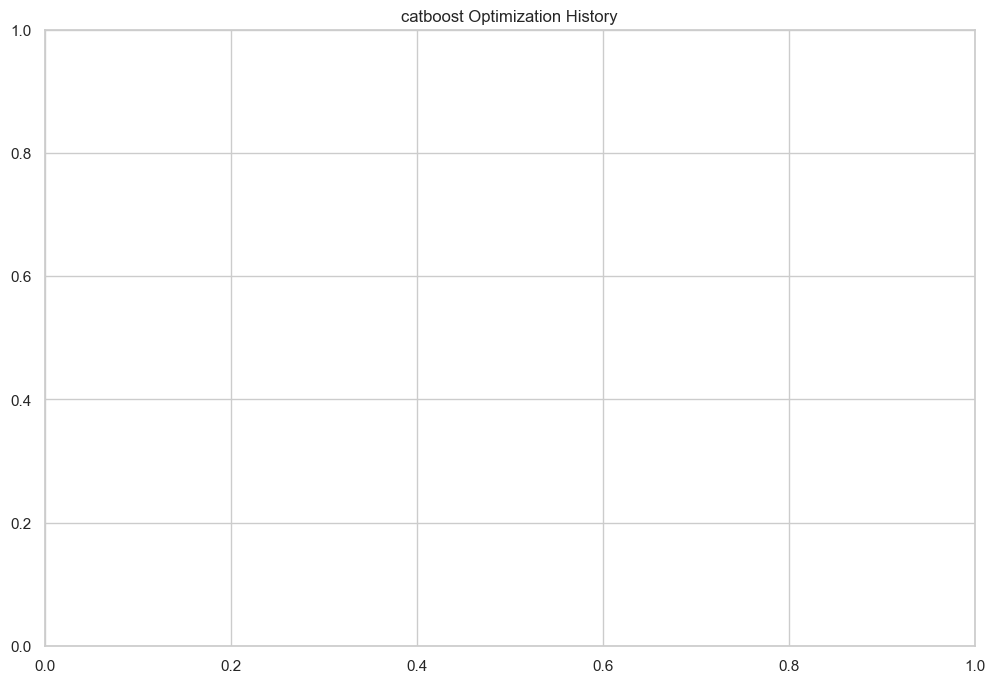


Total hyperparameter tuning time: 1170.66 seconds (19.51 minutes)
Generating meta-features from logistic...
Generating meta-features from xgboost...


[I 2025-03-10 16:38:47,240] A new study created in memory with name: no-name-a1b7b7d2-b9e5-4fad-9c77-317113c82fa8


Generating meta-features from catboost...
Generated meta-features from 3 models: logistic, xgboost, catboost
Optimizing meta-learner: logistic...


[I 2025-03-10 16:38:47,434] Trial 0 finished with value: 0.9396623387503207 and parameters: {'C': 0.05735268878335289}. Best is trial 0 with value: 0.9396623387503207.
[I 2025-03-10 16:38:47,878] Trial 1 finished with value: 0.945991691056965 and parameters: {'C': 0.35143486017780406}. Best is trial 1 with value: 0.945991691056965.
[I 2025-03-10 16:38:48,120] Trial 2 finished with value: 0.9469822377019629 and parameters: {'C': 0.9814222034646726}. Best is trial 2 with value: 0.9469822377019629.
[I 2025-03-10 16:38:48,377] Trial 3 finished with value: 0.9459772203044583 and parameters: {'C': 0.34812073150419176}. Best is trial 2 with value: 0.9469822377019629.
[I 2025-03-10 16:38:48,555] Trial 4 finished with value: 0.935873418780876 and parameters: {'C': 0.021719188239556556}. Best is trial 2 with value: 0.9469822377019629.
[I 2025-03-10 16:38:48,894] Trial 5 finished with value: 0.9419842342111824 and parameters: {'C': 0.09710330139210134}. Best is trial 2 with value: 0.9469822377019

Best logistic meta-learner params: {'C': 2.175062852129673}
Optimizing meta-learner: xgb...


[I 2025-03-10 16:38:56,006] Trial 0 finished with value: 0.9494575348855477 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.027622414351761226}. Best is trial 0 with value: 0.9494575348855477.
[I 2025-03-10 16:38:56,470] Trial 1 finished with value: 0.949917224913691 and parameters: {'n_estimators': 88, 'max_depth': 4, 'learning_rate': 0.09332078477810833}. Best is trial 1 with value: 0.949917224913691.
[I 2025-03-10 16:38:56,798] Trial 2 finished with value: 0.945414252591223 and parameters: {'n_estimators': 75, 'max_depth': 3, 'learning_rate': 0.016381447910032713}. Best is trial 1 with value: 0.949917224913691.
[I 2025-03-10 16:38:57,516] Trial 3 finished with value: 0.9482362180753375 and parameters: {'n_estimators': 140, 'max_depth': 4, 'learning_rate': 0.14528732955915255}. Best is trial 1 with value: 0.949917224913691.
[I 2025-03-10 16:38:58,427] Trial 4 finished with value: 0.9496163409641014 and parameters: {'n_estimators': 174, 'max_depth': 4, 'learni

Best XGBoost meta-learner params: {'n_estimators': 166, 'max_depth': 2, 'learning_rate': 0.1553466598669551}
Optimizing meta-learner: catboost...


[I 2025-03-10 16:39:15,795] Trial 0 finished with value: 0.9476585205265089 and parameters: {'iterations': 124, 'depth': 3, 'learning_rate': 0.03951486960092621}. Best is trial 0 with value: 0.9476585205265089.
[I 2025-03-10 16:39:16,280] Trial 1 finished with value: 0.9506025474595102 and parameters: {'iterations': 131, 'depth': 5, 'learning_rate': 0.09013621181882027}. Best is trial 1 with value: 0.9506025474595102.
[I 2025-03-10 16:39:16,407] Trial 2 finished with value: 0.940126136870855 and parameters: {'iterations': 57, 'depth': 2, 'learning_rate': 0.011380674316722064}. Best is trial 1 with value: 0.9506025474595102.
[I 2025-03-10 16:39:17,041] Trial 3 finished with value: 0.9503796795171541 and parameters: {'iterations': 142, 'depth': 5, 'learning_rate': 0.14871630164564323}. Best is trial 1 with value: 0.9506025474595102.
[I 2025-03-10 16:39:17,903] Trial 4 finished with value: 0.9496407840733937 and parameters: {'iterations': 185, 'depth': 5, 'learning_rate': 0.15099550441086

Best CatBoost meta-learner params: {'iterations': 140, 'depth': 5, 'learning_rate': 0.10740440074050665}
Evaluating meta-learner: logistic...
logistic - Accuracy: 0.8085, AUC: 0.8977
Evaluating meta-learner: xgb...
xgb - Accuracy: 0.8016, AUC: 0.8990


[I 2025-03-10 16:39:29,326] A new study created in memory with name: no-name-3b8eea49-5a6b-4ccb-a8a4-5df622d5e9dc
[I 2025-03-10 16:39:29,330] Trial 0 finished with value: 0.9010050424080804 and parameters: {'weight_logistic': 0.4832886600597329, 'weight_xgb': 0.14959072687935046, 'weight_catboost': 0.3031909271692752}. Best is trial 0 with value: 0.9010050424080804.
[I 2025-03-10 16:39:29,333] Trial 1 finished with value: 0.900844986957465 and parameters: {'weight_logistic': 0.8125293690812658, 'weight_xgb': 0.40670612634783376, 'weight_catboost': 0.4675163174821635}. Best is trial 0 with value: 0.9010050424080804.
[I 2025-03-10 16:39:29,336] Trial 2 finished with value: 0.9004216998153409 and parameters: {'weight_logistic': 0.38890790775775463, 'weight_xgb': 0.824286063820643, 'weight_catboost': 0.5846646679177656}. Best is trial 0 with value: 0.9010050424080804.
[I 2025-03-10 16:39:29,339] Trial 3 finished with value: 0.9008383730958693 and parameters: {'weight_logistic': 0.803072423

Evaluating meta-learner: catboost...
catboost - Accuracy: 0.8056, AUC: 0.9014

Optimizing ensemble weights...


[I 2025-03-10 16:39:29,482] Trial 21 finished with value: 0.9012166859791424 and parameters: {'weight_logistic': 0.46595297551731674, 'weight_xgb': 0.18840077850109244, 'weight_catboost': 0.6934210527855422}. Best is trial 19 with value: 0.9012219770684189.
[I 2025-03-10 16:39:29,489] Trial 22 finished with value: 0.9012166859791426 and parameters: {'weight_logistic': 0.4640067257867834, 'weight_xgb': 0.19607216597585475, 'weight_catboost': 0.7140192571371862}. Best is trial 19 with value: 0.9012219770684189.
[I 2025-03-10 16:39:29,498] Trial 23 finished with value: 0.9012272681576956 and parameters: {'weight_logistic': 0.5811604260557818, 'weight_xgb': 0.21425862547067503, 'weight_catboost': 0.8080558153589704}. Best is trial 23 with value: 0.9012272681576956.
[I 2025-03-10 16:39:29,535] Trial 24 finished with value: 0.9009984285464847 and parameters: {'weight_logistic': 0.6338599818141065, 'weight_xgb': 0.4907446492620352, 'weight_catboost': 0.8543887859821477}. Best is trial 23 with


Optimized meta-learner weights:
logistic: 0.3537
xgb: 0.0719
catboost: 0.5745

===== DEFAULT THRESHOLD EVALUATION =====
Default Threshold: 0.5
Validation Accuracy: 0.8045
Validation AUC: 0.9014

Default Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       863
           1       0.81      0.80      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


===== THRESHOLD OPTIMIZATION WITH OPTUNA =====


[I 2025-03-10 16:39:30,386] Trial 66 finished with value: 0.8102357676825762 and parameters: {'threshold': 0.5650679315749679}. Best is trial 23 with value: 0.8136860264519838.
[I 2025-03-10 16:39:30,390] Trial 67 finished with value: 0.8136860264519838 and parameters: {'threshold': 0.540150882766013}. Best is trial 23 with value: 0.8136860264519838.
[I 2025-03-10 16:39:30,395] Trial 68 finished with value: 0.8085106382978723 and parameters: {'threshold': 0.5191711901279389}. Best is trial 23 with value: 0.8136860264519838.
[I 2025-03-10 16:39:30,399] Trial 69 finished with value: 0.80448533640023 and parameters: {'threshold': 0.5018992585050437}. Best is trial 23 with value: 0.8136860264519838.
[I 2025-03-10 16:39:30,403] Trial 70 finished with value: 0.8050603795284647 and parameters: {'threshold': 0.4891800413988359}. Best is trial 23 with value: 0.8136860264519838.
[I 2025-03-10 16:39:30,408] Trial 71 finished with value: 0.8131109833237493 and parameters: {'threshold': 0.538864504

Optimal Threshold: 0.5357
Optimal Validation Accuracy: 0.8137
Improvement: 0.9201%

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       863
           1       0.83      0.79      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739


Total ensemble building time: 1217.56 seconds (20.29 minutes)

===== FINAL EVALUATION =====
Default Threshold (0.5) Accuracy: 0.8045
Optimal Threshold (0.5357) Accuracy: 0.8137
Improvement: 0.9201%

Final Classification Report (Optimized):
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       863
           1       0.83      0.79      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81

In [57]:
import os
import time

os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count())
os.environ["VECLIB_MAXIMUM_THREADS"] = str(os.cpu_count())

start_time = time.time()

def run_spaceship_titanic_solution():
    print("===== DATA PREPARATION =====")
    data_dict = prepare_spaceship_data(train_data, test_data)

    print("\n===== FEATURE SELECTION =====")
    X_train_selected, X_val_selected, X_test_selected = select_best_features(
        data_dict['X_train'],
        data_dict['y_train'],
        data_dict['X_val'],
        data_dict['X_test']
    )

    print("\n===== BUILDING ADVANCED ENSEMBLE =====")
    ensemble_results = build_advanced_ensemble(
        X_train_selected,
        data_dict['y_train'],
        X_val_selected,
        data_dict['y_val'],
        X_test_selected
    )

    print("\n===== FINAL EVALUATION =====")
    optimal_threshold = ensemble_results['thresholds']['optimal']
    optimal_accuracy = ensemble_results['performance']['optimal_accuracy']
    default_accuracy = ensemble_results['performance']['default_accuracy']

    print(f"Default Threshold (0.5) Accuracy: {default_accuracy:.4f}")
    print(f"Optimal Threshold ({optimal_threshold:.4f}) Accuracy: {optimal_accuracy:.4f}")
    print(f"Improvement: {(optimal_accuracy - default_accuracy) * 100:.4f}%")

    optimized_val_preds = ensemble_results['validation_binary_predictions']['optimized']

    print("\nFinal Classification Report (Optimized):")
    print(classification_report(data_dict['y_val'], optimized_val_preds))

    print("\n===== GENERATING SUBMISSION =====")
    final_test_preds = ensemble_results['final_predictions']
    final_test_labels = (final_test_preds > optimal_threshold).astype(bool)

    submission = pd.DataFrame({
        'PassengerId': data_dict['test_ids'],
        'Transported': final_test_labels
    })

    submission_path = 'submission.csv'
    submission.to_csv(submission_path, index=False)
    print(f"Submission file created: {submission_path}")
    print(f"Using optimal threshold: {optimal_threshold:.4f}")

    return {
        'data_dict': data_dict,
        'ensemble_results': ensemble_results,
        'final_metrics': {
            'default_accuracy': default_accuracy,
            'optimal_accuracy': optimal_accuracy,
            'auc': ensemble_results['performance']['auc']
        },
        'submission': submission
    }

results = run_spaceship_titanic_solution()